In [1]:
from pymongo import MongoClient
from googletrans import Translator
from bson.objectid import ObjectId
import tqdm
import re
from nltk import ngrams
import Levenshtein
import pickle
import os
from gensim.test.utils import lee_corpus_list
from gensim.models import Word2Vec, Doc2Vec
import json
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt


In [2]:
client = MongoClient(host='103.252.1.144', username='admin', password = 'CIST2o20')
cb = client['human_resources']['career_builder']
cv = cb.find({'eng_experience':{'$exists':True}, 'fulltext':{'$regex':'.*developer.*'}})
jpt = client['human_resources']['job_posting_topcv']
jd = jpt.find({'eng_job_description':{'$regex':'.*developer.*'}})

In [9]:
class CSO_classifier():
    def __init__(self):
        path = './ontology/ontology/'
        self.skill_ontology = {}
        for file in os.listdir(path):
            if file.endswith(".p"):
                with open(os.path.join(path, file), 'rb') as f:
                    try:
                        while True:
                            self.skill_ontology[file.replace('_ontology.p','')]=pickle.load(f)
                    except EOFError:
                        pass
        self.doc2vec = Doc2Vec()

    def concept_similarity(self, sentence):
        sentence = re.sub(r"[-()\"/@;:<>{}`=~|.!?,]", " ", sentence).lower()

        uni_gram = ngrams(sentence.split(), 1)
        bi_gram = ngrams(sentence.split(), 2)
        tri_gram = ngrams(sentence.split(), 3)
        uni_gram = [i[0] for i in list(uni_gram)]
        bi_gram = ['{} {}'.format(i[0],i[1]) for i in list(bi_gram)]
        tri_gram = ['{} {} {}'.format(i[0],i[1], i[2]) for i in list(tri_gram)]
        n_gram = uni_gram + bi_gram + tri_gram

        skill_from_cv_or_jd = []
        skill_find_out = []
        
        for i in n_gram:
            for o_k in self.skill_ontology.keys():
                for k in self.skill_ontology[o_k]['topics_wu'].values():
                    if Levenshtein.ratio(i, str(k)) > 0.94:
                        if k in self.skill_ontology[o_k]['broaders']:
                            if o_k+str(k) not in skill_find_out:
                                skill = {'rank_0': o_k, 'rank_1': self.skill_ontology[o_k]['broaders'][k], 'rank_2': str(k)}
                                skill_from_cv_or_jd.append(skill)
                                skill_find_out.append(o_k+str(k))



        soft_skill = [i for i in skill_from_cv_or_jd if i['rank_0']=='softskill']
        general_skill = [i for i in skill_from_cv_or_jd if i['rank_0']=='general']
        other_skill = [i for i in skill_from_cv_or_jd if (i['rank_0']!='softskill' and i['rank_0']!='general')]

        return general_skill+other_skill, soft_skill

    def semantic_similarity(self,sentence):
        pass

In [18]:
def get_index(cv=None, jd=None):
    index = {}
    cnt = 0
    if cv==None and jd==None:
        path = './ontology/ontology/'
        skill_ontology = {}
        for file in os.listdir(path):
            if file.endswith(".p"):
                with open(os.path.join(path, file), 'rb') as f:
                    try:
                        while True:
                            skill_ontology[file.replace('_ontology.p','')]=pickle.load(f)
                    except EOFError:
                        pass
        for i in skill_ontology:
            if i not in index:
                index[i] = cnt
                cnt+=1
            for k in skill_ontology[i]['broaders']:
                if k not in index:
                    index[k] = cnt
                    cnt+=1
                if ' '.join(skill_ontology[i]['broaders'][k]) not in index:
                    index[' '.join(skill_ontology[i]['broaders'][k])] = cnt
                    cnt+=1
                for j in skill_ontology[i]['broaders'][k]: 
                    if j not in index:
                        index[j] = cnt
                        cnt+=1
    else:
        for i in cv:
            if ' '.join(i['rank_1']) not in index:
                index[' '.join(i['rank_1'])] = cnt
                cnt+=1
            if i['rank_2'] not in index:
                index[i['rank_2']] = cnt
                cnt+=1
            if i['rank_0'] not in index:
                index[i['rank_0']] = cnt
                cnt+=1

        for i in jd:
            if ' '.join(i['rank_1']) not in index:
                index[' '.join(i['rank_1'])] = cnt
                cnt+=1
            if i['rank_2'] not in index:
                index[i['rank_2']] = cnt
                cnt+=1
            if i['rank_0'] not in index:
                index[i['rank_0']] = cnt
                cnt+=1
    return index

In [23]:
def build_graph(skill, index, only_general=True):
    # graph = {}
    # for i in skill:
    #     graph[i['rank_0']]={}
    # for i in skill:
    #     graph[i['rank_0']][' '.join(i['rank_1'])] = set()
    # for i in skill:
    #     graph[i['rank_0']][' '.join(i['rank_1'])].add(i['rank_2'])
    # for i in skill:
    #     graph[i['rank_0']][' '.join(i['rank_1'])] = list(graph[i['rank_0']][' '.join(i['rank_1'])])

    cnt = {}
    for j in cso_classifier.skill_ontology:
        for i in c['Skills']['Technical_skills']:
            if i['rank_0'] == j:
                if i['rank_0'] not in cnt:
                    cnt[i['rank_0']]=1
                else:
                    cnt[i['rank_0']]+=1
    remove = []
    for i in cnt:
        if cnt[i]<4:
            remove.append(i)
            remove.append(i+' developer')
    
    graph = {}
    for i in skill:
        if i['rank_0'] not in remove:
            graph[i['rank_0'].replace('_', ' ')]={}
    for i in skill:
        for j in i['rank_1']:
            if i['rank_0'] not in remove and j not in remove and  ' '.join([lemma.lemmatize(k) for k in j.split(' ')]).replace('-', ' ') not in remove and i['rank_2'] not in remove:
                graph[i['rank_0'].replace('_', ' ')][' '.join([lemma.lemmatize(k) for k in j.split(' ')]).replace('-', ' ').replace('_', ' ')] = set()
    for i in skill:
        for j in i['rank_1']:
            if i['rank_0'] not in remove and j not in remove and  ' '.join([lemma.lemmatize(k) for k in j.split(' ')]).replace('-', ' ') not in remove and i['rank_2'] not in remove:
                graph[i['rank_0'].replace('_', ' ')][' '.join([lemma.lemmatize(k) for k in j.split(' ')]).replace('-', ' ').replace('_', ' ')].add(' '.join([lemma.lemmatize(k) for k in i['rank_2'].split(' ')]))
    for i in skill:
        for j in i['rank_1']:
            if i['rank_0'] not in remove and j not in remove and  ' '.join([lemma.lemmatize(k) for k in j.split(' ')]).replace('-', ' ') not in remove and i['rank_2'] not in remove:
                graph[i['rank_0'].replace('_', ' ')][' '.join([lemma.lemmatize(k) for k in j.split(' ')]).replace('-', ' ').replace('_', ' ')] = list(graph[i['rank_0'].replace('_', ' ')][' '.join([lemma.lemmatize(k) for k in j.split(' ')]).replace('-', ' ')])
        
    temp = []
    cnt = 0

    if only_general:
        if i =='general':
            for j in graph['general']:
                temp.append({'from' :'general','to': j})
                for k in graph[i][j]:
                    temp.append({'from' :j,'to': k})
    else:
        for i in graph:
            if i =='general':
                for j in graph[i]:
                    temp.append({'from' :i,'to': j})
                    for k in graph[i][j]:
                        temp.append({'from' :j,'to': k})

    df = pd.DataFrame(temp)
    df=df.drop_duplicates()
    G = nx.from_pandas_edgelist(df, 'from', 'to')

    df2 = df.replace({'from': index, 'to':index})
    G_number = nx.from_pandas_edgelist(df2, 'from', 'to')

    return G, G_number, df, graph


In [14]:
def draw_graph(G):
    plt.figure(figsize=(12,12))
    pos = nx.spring_layout(G)
    nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos, node_size = 4500)
    plt.show()

In [15]:
ontology = {'A':[], 'JD': [], 'R': []}

In [16]:
c = {'Profile': None, 'Work_history': None, 'Education': None, 'Course': None, 'Skills': {}, 'Pos': None, 'Others': None}
d = {'Information': None, 'Descriptions': None, 'Required': None, 'Skills': {}}

cso_classifier = CSO_classifier()

c['Skills']['Technical_skills'], c['Skills']['Soft_skills'] = cso_classifier.concept_similarity(' '.join(cv[0]['eng_experience']+cv[0]['eng_skills']))
d['Skills']['Technical_skills'], d['Skills']['Soft_skills'] = cso_classifier.concept_similarity(jd[1]['title']+' '+' '.join(jd[1]['eng_job_description']+jd[1]['eng_requirement']))

In [24]:
index = get_index(c['Skills']['Technical_skills'], d['Skills']['Technical_skills'])
graph_cv = build_graph(c['Skills']['Technical_skills'], index)
graph_jd = build_graph(d['Skills']['Technical_skills'], index)


In [306]:
df_list = []
df_list_jd = []

In [8]:
# for i in range(10):
#     c['Skills']['Technical_skills'], c['Skills']['Soft_skills'] = cso_classifier.concept_similarity(' '.join(cv[i]['eng_experience']+cv[i]['eng_skills']))
#     d['Skills']['Technical_skills'], d['Skills']['Soft_skills'] = cso_classifier.concept_similarity(jd[i]['title']+' '+' '.join(jd[i]['eng_job_description']+jd[i]['eng_requirement']))
#     index = get_index(c['Skills']['Technical_skills'], d['Skills']['Technical_skills'])
#     graph_cv = build_graph(c['Skills']['Technical_skills'], index)
#     graph_jd = build_graph(d['Skills']['Technical_skills'], index)
#     df_list.append(graph_cv[2])
#     df_list_jd.append(graph_jd[2])

# with open('cv_jd.txt','w', encoding='utf8') as f:
#     for i in range(10):
#         f.write(str(i)+'\n')
#         f.write(' '.join(cv[i]['eng_experience']+cv[i]['eng_skills'])+'\n')
#         f.write("__________________________________________________________________________\n")
#     f.write('\n')
#     f.write('***************************************************\n')
#     for i in range(10):
#         f.write(str(i)+'\n')
#         f.write(jd[i]['title']+' '+' '.join(jd[i]['eng_job_description']+jd[i]['eng_requirement'])+'\n')
#         f.write(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>\n")

# cnt=0
# for i in df_list_jd:
#     i.to_csv(str(cnt)+'_jd.csv')
#     cnt+=1


In [30]:
cnt = {}
for j in cso_classifier.skill_ontology:
    for i in c['Skills']['Technical_skills']:
        if i['rank_0'] == j:
            if i['rank_0'] not in cnt:
                cnt[i['rank_0']]=1
            else:
                cnt[i['rank_0']]+=1
keep = []
for i in cnt:
    if cnt[i]>4:
        keep.append(i)
keep

['general']

In [301]:
cso_classifier.skill_ontology['fullstack']['broaders']

{'avl tree': ['data structures'],
 'breadth first search': ['search algorithms'],
 'build': ['fullstack developer'],
 'deploy': ['fullstack developer'],
 'depth first search': ['search algorithms'],
 'groovy': ['programming language'],
 'j2ee': ['framework'],
 'javase': ['framework'],
 'java core': ['framework'],
 'mongo': ['databases'],
 'node': ['framework'],
 'odm': ['databases'],
 'orm': ['databases'],
 'postgresql': ['databases'],
 'rest': ['knowledge'],
 'rails': ['framework'],
 'saml': ['authentication'],
 'scala': ['programming language'],
 'testing': ['fullstack developer'],
 'algorithms': ['knowledge'],
 'amazon athena': ['aws'],
 'amazon aurora': ['aws'],
 'amazon dynamodb': ['aws'],
 'amazon ebs': ['aws'],
 'amazon elasticache': ['aws'],
 'amazon emr': ['aws'],
 'amazon rds': ['aws'],
 'amazon redshift': ['aws'],
 'amazon s3': ['aws'],
 'amazon sqs': ['aws'],
 'appveyor': ['ci/cd'],
 'arangodb': ['databases'],
 'array': ['data structures'],
 'aws': ['databases', 'monitoring

In [302]:
for i in c['Skills']['Technical_skills']:
    if i['rank_0'] == 'data_science':
        print(i)

{'rank_0': 'data_science', 'rank_1': ['datascience'], 'rank_2': 'databases'}
{'rank_0': 'data_science', 'rank_1': ['programming language'], 'rank_2': 'python'}


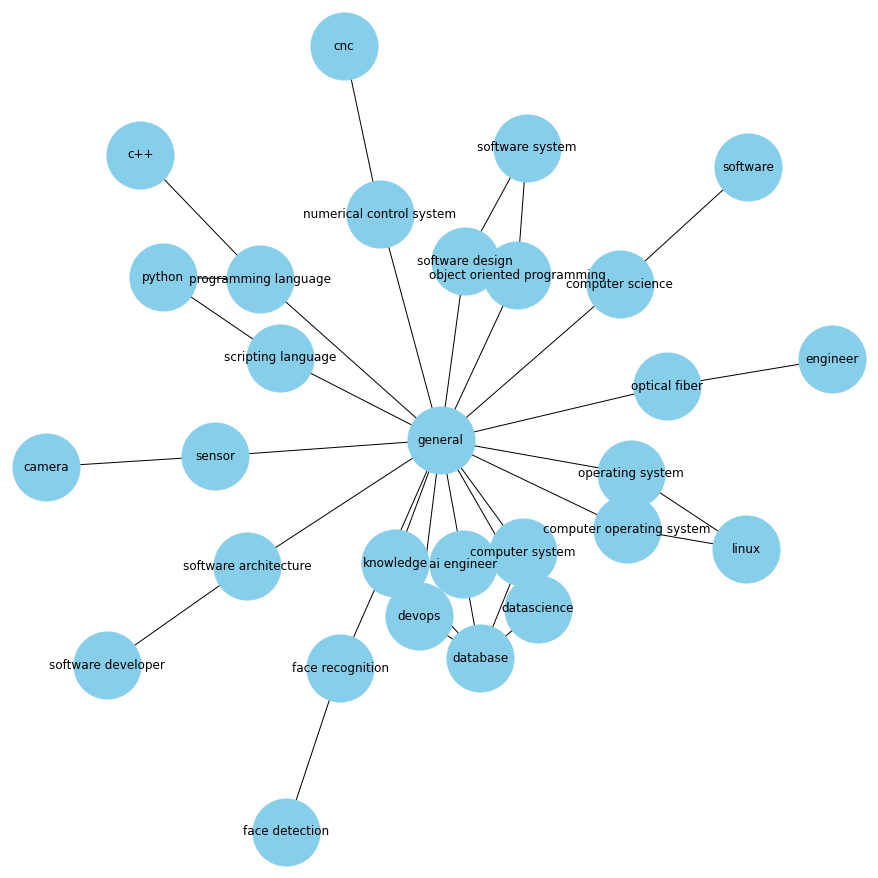

In [22]:
# draw_graph(graph_cv[1])
draw_graph(graph_cv[0])

In [ ]:
['Software Team leader \n2006 - 2009:\rSimono JSC (worked in Japan)\rCNC Engineer: \r- Drawing machine element\r- Programming on CNC\r- Manufacturing part (of machine)\r- Material, product management\r- Repair mistake\r- Inspector\r- Report to Japanese Manager\r  2011 – 2017:\rFutech JSC (Vietnam)\rSoftware Developer:\r- Developed project C# (application desktop)\r- Integrated devices: cameras, controllers to software\r- Researched new cameras, controllers\r- Deployed software\r- Database management\r- Supported customers\r 2017-2020:\rKztek JSC (branch of Futech)\rSoftware Developer, Project Manager:\r- Train teams\r- Design logic software system\r- Developed software on Linux (Python, Qt C++)\r- Research ALPR, Face Detection\r- Maintain android projects',
 'Programming C#, C++',
 'Autocad',
 'Research, integrate camera, controller',
 'Microsoft word, excel, powerpoint',
 'CNC programming',
 'Python programming',
 'English - Intermediate',
 'Japan - Intermediate']

In [27]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to C:\Users\ASUS
[nltk_data]     ZENBOOK\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\ASUS
[nltk_data]     ZENBOOK\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\omw-1.4.zip.


True

In [20]:
from nltk.stem import WordNetLemmatizer
lemma = WordNetLemmatizer()
' '.join([lemma.lemmatize(i) for i in 'software architectures'.split(' ')])

'software architecture'

In [ ]:
graph = {}
skill = c['Skills']['Technical_skills'][0]
for i in skill:
    graph[i['rank_0']]={}
for i in skill:
    graph[i['rank_0']][' '.join(i['rank_1'])] = set()
for i in skill:
    graph[i['rank_0']][' '.join(i['rank_1'])].add(i['rank_2'])
for i in skill:
    graph[i['rank_0']][' '.join(i['rank_1'])] = list(graph[i['rank_0']][' '.join(i['rank_1'])])
    
temp = []
cnt = 0
for i in graph:
    for j in graph[i]:
        temp.append({'from' :i,'to': j})
        for k in graph[i][j]:
            temp.append({'from' :j,'to': k})

df = pd.DataFrame(temp)
G = nx.from_pandas_edgelist(df, 'from', 'to')

df = df.replace({'from': index, 'to':index})
G_number = nx.from_pandas_edgelist(df, 'from', 'to')

return G, G_number

In [45]:
graph = {}
skill = c['Skills']['Technical_skills'][0]
for i in skill:
    graph[i['rank_0']]={}
for i in skill:
    for j in i['rank_1']:
        graph[i['rank_0']][' '.join([lemma.lemmatize(k) for k in j.split(' ')]).replace('-', ' ')] = set()
for i in skill:
    for j in i['rank_1']:
        graph[i['rank_0']][' '.join([lemma.lemmatize(k) for k in j.split(' ')]).replace('-', ' ')].add(' '.join([lemma.lemmatize(k) for k in i['rank_2'].split(' ')]))
for i in skill:
    for j in i['rank_1']:
        graph[i['rank_0']][' '.join([lemma.lemmatize(k) for k in j.split(' ')]).replace('-', ' ')] = list(graph[i['rank_0']][' '.join([lemma.lemmatize(k) for k in j.split(' ')]).replace('-', ' ')])
graph

{'general': {'computer science': ['software'],
  'numerical control system': ['cnc'],
  'optical fiber': ['engineer'],
  'io developer': ['project'],
  'computer system': ['database'],
  'backend developer': ['database'],
  'knowledge': ['database'],
  'fullstack developer': ['database'],
  'devops': ['database'],
  'datascience': ['database'],
  'ai engineer': ['database'],
  'computer operating system': ['linux'],
  'operating system': ['linux'],
  'scripting language': ['python'],
  'programming language': ['c++', 'python'],
  'smart phone': ['android'],
  'smartphone': ['android'],
  'smartphones': ['android'],
  'sensor': ['camera'],
  'software architecture': ['software developer'],
  'software design': ['software system'],
  'object oriented programming': ['software system'],
  'face recognition': ['face detection']}}

In [38]:
' '.join([lemma.lemmatize(k) for k in 'smartphones'.split(' ')])

'smartphones'

In [58]:
from gensim.models import doc2vec
from collections import namedtuple

dataset = json.load(open('/home/linhhoang/skill-matching/data/data_wiki/skill_wiki_frontend.json'))

docs = []
analyzedDocument = namedtuple('AnalyzedDocument', 'words tags')

for description in dataset.keys():
    tags = description
    words = re.sub('\s\w{1,1}\s', '',dataset[description])
    docs.append(analyzedDocument(words, tags))

In [50]:
model = doc2vec.Doc2Vec(docs, vector_size = 100, window = 10, min_count = 1, workers = 4, epochs = 20)

In [60]:
# model.docvecs.most_similar(model.infer_vector(docs[0].words))

Word2Vec model [4]
which is trained on Wikipedia pages of the skills in the
dictionary, job descriptions from multiple job postings
and course curriculum of universities

In [8]:
from gensim.test.utils import lee_corpus_list
from gensim.models import Word2Vec

client = MongoClient(host='103.252.1.144', username='admin', password = 'CIST2o20')
cb = client['human_resources']['career_builder']
cv = cb.find({'eng_experience':{'$exists':True}, 'fulltext':{'$regex':'.*developer.*'}})
jpt = client['human_resources']['job_posting_topcv']
jd = jpt.find({'eng_job_description':{'$regex':'.*developer.*'}})

corpus = []
for i in jd:
    sentence = i['title']+' '+' '.join(i['eng_job_description']+i['eng_requirement']) 
    sentence = re.sub(r"[-()\"/@;:<>{}`=~|.!?,•]", " ", sentence).lower()
    corpus_ = list(ngrams(sentence.split(), 1))
    corpus_ = [i[0] for i in list(corpus_)]
    corpus.append(corpus_)

model = Word2Vec(corpus, vector_size=24, epochs=100)
word_vectors = model.wv

In [9]:
word_vectors.similarity('writing', 'reading')

0.5334272

In [10]:
word_vectors.similarity('python', 'c#')

0.52473044

In [11]:
from gensim.test.utils import lee_corpus_list
from gensim.models import Word2Vec

client = MongoClient(host='103.252.1.144', username='admin', password = 'CIST2o20')
cb = client['human_resources']['career_builder']
cv = cb.find({'eng_experience':{'$exists':True}, 'fulltext':{'$regex':'.*developer.*'}})
jpt = client['human_resources']['job_posting_topcv']
jd = jpt.find({'eng_job_description':{'$regex':'.*developer.*'}})

corpus = []
for i in jd:
    sentence = [i['title']]+i['eng_job_description']+i['eng_requirement']
    sentence = [re.sub(r"[-()\"/@;:<>{}`=~|.!?,•]", " ", i).lower().strip() for i in sentence]
    corpus_ = [re.sub(r'\s+', ' ', i).split(' ') for i in sentence]
    corpus+=corpus_

model = Word2Vec(corpus, vector_size=24, epochs=100)
word_vectors = model.wv

In [12]:
word_vectors.similarity('writing', 'reading')

0.47297662

In [13]:
word_vectors.similarity('coding', 'programming')


0.27992797

In [5]:
import json
f = open('/home/linhhoang/skill-matching/data/data_wiki/skill_wiki_general.json','r')
a=f.read()
data_w2v = json.loads(a)

In [6]:
len(data_w2v.keys())

2495

In [7]:
path = 'https://en.wikipedia.org/wiki/'
cnt = 0
start = False
# for i in skill_ontology:
for s in skill_ontology['general']['topics_wu']:
    cnt+=1
    if s=='electrical_discharge_machining':
        start = True
    if start == True:
        if s not in data_w2v:
            a = get_text(path+s)
            if len(a) > 2000:
                data_w2v[s] = a
                print(s, end='\r')

In [1]:
len(data_w2v)

NameError: name 'data_w2v' is not defined

In [30]:
import json
with open('/home/linhhoang/skill-matching/data/data_wiki/skill_wiki_general.json', 'w') as f:
    json.dump(data_w2v, f, indent=4)

In [216]:
data_w2v = {}
path = 'https://en.wikipedia.org/wiki/'
for i in skill_ontology:
    for s in skill_ontology[i]['topics_wu']:
        if s not in data_w2v:
            a = get_text(path+s)
            if len(a) > 2000:
                data_w2v[s] = a
                print(s, end='\r')

KeyboardInterrupt: 

In [220]:
import json
with open('skill_wiki.json', 'w') as f:
    json.dump(data_w2v, f, indent=4)

In [189]:
import xml.etree.ElementTree as ET
cnt=0
for event, elem in ET.iterparse("/home/linhhoang/skill-matching/enwiki-latest-abstract.xml"):
    print(event,end = ' ')
    cnt+=1
    if cnt == 100:
        break

end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end 

In [184]:
a = ET.iterparse("/home/linhhoang/skill-matching/enwiki-latest-abstract.xml")